In [30]:
%pip install -r ./requirements.txt

  Cloning https://github.com/openai/CLIP.git (to revision dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1) to /tmp/pip-install-gnibqh2j/clip_b716b9f1fff14f5894c697ea2019e795
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-gnibqh2j/clip_b716b9f1fff14f5894c697ea2019e795
  Running command git rev-parse -q --verify 'sha^dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1'
  Running command git fetch -q https://github.com/openai/CLIP.git dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [31]:
%pip freeze | grep -i 'torch'

torch==2.6.0+cpu
torchvision==0.21.0+cpu
Note: you may need to restart the kernel to use updated packages.


# Libraries

In [32]:
import utils
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import read_image
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import albumentations as A
import pickle as pkl
from UNET_model import UNET 


random.seed(42)

# Data Preparation
In this step, I will be using the `datasets` python library to load both the image and mask together to make it easier for downstream tasks to process the data.
<br>

Once the dataset can be loaded, image augmentation will be performed with the `albumentations` python library to ensure the image size is consistent and our training data is robust.

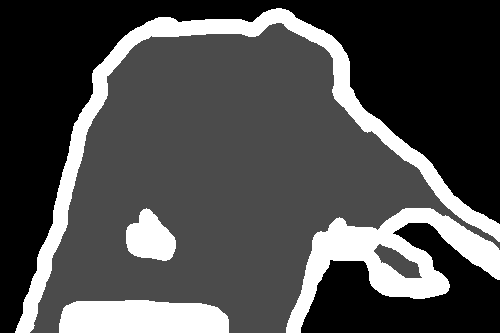

In [33]:
# image_I = Image.open("images/Abyssinian_1_mask.png").convert(mode="I")
image_L = Image.open("Dataset/TrainVal/label/american_bulldog_111.png").convert(mode="L")
# image_RGB = Image.open("images/Abyssinian_1_mask.png").convert(mode="RGB")

# print(np.unique(np.array(image_I)))
# print(np.unique(np.array(image_L)))
# print(np.unique(np.array(image_RGB)))
# print(np.array(image_L))
image_L



In [34]:
# investigating the unique values in the segmentation mask for both training and test
def get_valid_masks(dataset_dir):
    classes = set()
    masks = os.listdir(dataset_dir)
    valid_masks = masks.copy()
    missing_masks = []

    for mask in masks:
        mask_img = read_image(os.path.join(dataset_dir, mask))
        unique_mask_values = mask_img.unique()
        # print(unique_mask_values, mask)
        # print(unique_mask_values[2].item())
        # print(len(unique_mask_values))

        # corrupted / missing mask
        if (len(unique_mask_values)) != 3:
            # mark them for removal in dataset
            print(f"Missing mask: {mask}")
            missing_masks.append(mask)
            valid_masks.remove(mask)
            continue

        background = unique_mask_values[0].item()
        subject = unique_mask_values[1].item()
        boundary = unique_mask_values[2].item()

        classes.add(background)
        classes.add(subject)
        classes.add(boundary)

    print(f"Classes: {classes}")
    return valid_masks

TRAIN_MASK_DIR = "Dataset/TrainVal/label"
TEST_MASK_DIR = "Dataset/Test/label"
train_valid_masks = get_valid_masks(TRAIN_MASK_DIR)
test_valid_masks = get_valid_masks(TEST_MASK_DIR)


Missing mask: Egyptian_Mau_196.png
Missing mask: miniature_pinscher_14.png
Missing mask: Egyptian_Mau_162.png
Missing mask: saint_bernard_108.png
Missing mask: saint_bernard_15.png
Missing mask: Egyptian_Mau_165.png
Missing mask: leonberger_18.png
Classes: {0, 1, 2, 255}
Missing mask: Persian_259.png
Missing mask: Egyptian_Mau_177.png
Missing mask: Egyptian_Mau_20.png
Missing mask: Egyptian_Mau_167.png
Missing mask: Abyssinian_34.png
Missing mask: saint_bernard_60.png
Missing mask: keeshond_7.png
Missing mask: Egyptian_Mau_139.png
Missing mask: Egyptian_Mau_191.png
Missing mask: wheaten_terrier_195.png
Missing mask: Egyptian_Mau_129.png
Missing mask: japanese_chin_199.png
Missing mask: Egyptian_Mau_145.png
Missing mask: staffordshire_bull_terrier_2.png
Missing mask: saint_bernard_78.png
Missing mask: staffordshire_bull_terrier_22.png
Classes: {0, 1, 2, 255}


## Data Loading

In [35]:

class PetDataset(Dataset):
    def __init__(self, image_dir, mask_dir, valid_masks, transform = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = valid_masks

        # print(f"----Initialized Values----")
        # print(f"{self.image_dir} | {self.mask_dir} | {self.transform} | {self.images}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # print(f"index: {index}")
        
        img_path = os.path.join(self.image_dir, self.images[index]).replace(".png", ".jpg")
        # print(f"Image path: {img_path}")
        mask_path = os.path.join(self.mask_dir, self.images[index])
        # print(f"Mask path: {mask_path}")

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # gray scale
        # mask[mask == 1 or mask == 2] = 1 # convert both cat and dog into a combined mask label for object
        # print(f"Image Type: {type(image)}")
        # print(f"Mask Type: {type(mask)}")

        
        if self.transform is not None:
            # print(f"Shape of image: {image.shape} Shape of mask: {mask.shape}")
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
            # print(f"New shape of image: {image.shape} New shape of mask: {mask.shape}")


        return image, mask

## Image Augmentations
Based on this [guide](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), since the models tend to receive a fixed size tensor, there are a few ways to achieve this.
- Resizing
- Cropping & Padding
<br />

The former way is straight forward but can lead to a loss in image quality, while the latter way is a good balance without compromising the image quality. As part of the first iteration, I will use the resizing augmentation.

In [36]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

transform_all = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),               
    A.Rotate(limit=(-40,40)),
    A.ElasticTransform(p=0.5),     
    A.Normalize(), # does not affect mask
    A.ToTensorV2(transpose_mask=True),           
], seed=137, strict=True)


transform_image = A.Compose([
    A.ColorJitter(),    
    A.Normalize(), # go before totensor since normalize needs the img as a float  
    A.ToTensorV2(transpose_mask=True),           
], seed=137, strict=True)

transform_mask = A.Compose([
    A.Normalize(), # go before totensor since normalize needs the img as a float  
    A.ToTensorV2(transpose_mask=True),           
], seed=137, strict=True)
 


In [37]:
TRAIN_IMAGE_DIR = "Dataset/TrainVal/color"
TRAIN_MASK_DIR = "Dataset/TrainVal/label"
TEST_IMAGE_DIR = "Dataset/Test/color"
TEST_MASK_DIR = "Dataset/Test/label"

train_val_dataset = PetDataset(image_dir=TRAIN_IMAGE_DIR, mask_dir=TRAIN_MASK_DIR, valid_masks=train_valid_masks, transform=transform_all)
test_dataset = PetDataset(image_dir=TEST_IMAGE_DIR,valid_masks=test_valid_masks, mask_dir=TEST_MASK_DIR)

In [38]:
train_dataset, val_dataset = random_split(train_val_dataset, [0.8, 0.2])

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
train_image, train_mask = next(iter(train_dataloader))
print(f"Image batch shape: {train_image.size()}")
print(f"Mask batch shape: {train_mask.size()}")
print(f"Mask unique values: {torch.unique(train_mask)}")
# print(f"Mask unique values: {torch.unique(train_image)}")

Image batch shape: torch.Size([1, 3, 128, 128])
Mask batch shape: torch.Size([1, 128, 128])
Mask unique values: tensor([  0.,  75., 255.])
Mask unique values: tensor([-2.1179, -2.1008, -2.0837, -2.0665, -2.0494, -2.0357, -2.0323, -2.0182,
        -2.0152, -2.0007, -1.9980, -1.9832, -1.9809, -1.9657, -1.9638, -1.9482,
        -1.9467, -1.9307, -1.9295, -1.9132, -1.9124, -1.8957, -1.8953, -1.8782,
        -1.8782, -1.8610, -1.8606, -1.8439, -1.8431, -1.8268, -1.8256, -1.8097,
        -1.8081, -1.8044, -1.7925, -1.7906, -1.7870, -1.7754, -1.7731, -1.7696,
        -1.7583, -1.7556, -1.7522, -1.7412, -1.7381, -1.7347, -1.7240, -1.7206,
        -1.7173, -1.7069, -1.7031, -1.6999, -1.6898, -1.6856, -1.6824, -1.6727,
        -1.6681, -1.6650, -1.6555, -1.6506, -1.6476, -1.6384, -1.6331, -1.6302,
        -1.6213, -1.6155, -1.6127, -1.6042, -1.5980, -1.5953, -1.5870, -1.5805,
        -1.5779, -1.5699, -1.5630, -1.5604, -1.5528, -1.5455, -1.5430, -1.5357,
        -1.5280, -1.5256, -1.5185, -1.510

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


torch.Size([1, 128, 128])


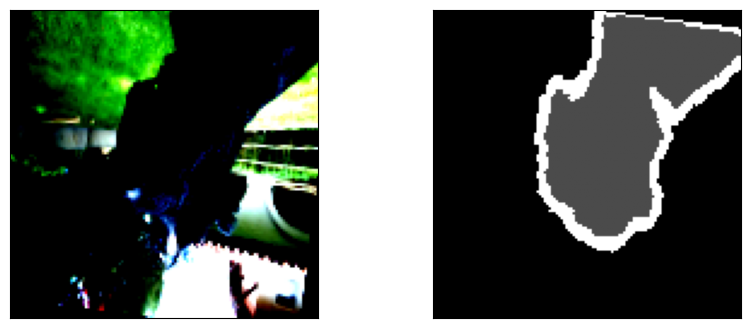

In [41]:

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
fig = plt.imshow(train_image.squeeze(0).permute(1,2,0))
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.subplot(1,2,2)
print(f"{train_mask.size()}")
fig = plt.imshow(train_mask.permute(1,2,0), cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [42]:

# save the dataset into a pickle file to be loaded in
with open("processed_dataset/train.pkl", "wb") as f:
    pkl.dump(train_dataset, f)

with open("processed_dataset/val.pkl", "wb") as f:
    pkl.dump(val_dataset, f)

with open("processed_dataset/test.pkl", "wb") as f:
    pkl.dump(test_dataset, f)

In [43]:

with open("processed_dataset/train.pkl", "rb") as f:
    train_dataset = pkl.load(f)

with open("processed_dataset/val.pkl", "rb") as f:
    val_dataset = pkl.load(f)

with open("processed_dataset/test.pkl", "rb") as f:
    test_dataset = pkl.load(f)

In [44]:

DEVICE =  torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (images, masks) in enumerate(loop):
        # print(f"images: {images.size()} masks: {masks.size()}")
        images = images.to(device=DEVICE)
        masks = masks.float().unsqueeze(1).to(device=DEVICE) # removes the channel on the mask

        # forward
        with torch.amp.autocast(device_type="cpu"): # convolutions are much faster in lower_precision_fp
            predictions = model(images)
            loss = loss_fn(predictions, masks)

        # backward
        optimizer.zero_grad() # in pytorch grad are accumulated, zero it to only account for the current batch of training.
        scaler.scale(loss).backward() # scale the gradients to prevent them from being flushed to 0 due to computational limits
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item()) # additional data to display in the loading bar

In [ ]:

BATCH_SIZE = 16
PIN_MEMORY = True
NUM_WORKERS = 4
LEARNING_RATE = 0.00005
LOAD_MODEL = False
NUM_EPOCHS = 5

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = utils.get_loaders(
    train_dataset,
    val_dataset,
    num_workers=NUM_WORKERS,
    batch_size=BATCH_SIZE,
)

if LOAD_MODEL:
    utils.load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

utils.check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    utils.save_checkpoint(checkpoint)

    # check accuracy
    utils.check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    utils.save_predictions_as_imgs(
        val_loader, model, folder="saved_images/", device=DEVICE
    )